# CLWW vs Ideal ORE

In [1]:
import collections
import math
from math import floor, log2
import numpy as np
import pandas as pd
from scipy.special import perm # for nPk 
from sympy.functions.combinatorial.numbers import stirling
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

## r(i, k) table

In [2]:
def trailing_zero(n):
    x = int(bin(n)[2:])
    count = 0
    while ((x & 1 ) == 0):
        x = x >> 1
        count += 1
    return count

def report_number(I, K):
    r = [[0]* (I + 1) for _ in range(K+1)]
    r[1][1] = 1
    for k in range(2, K+1):
        b = trailing_zero(k-1)
        for i in range(1, I+1):
            r[k][i] = r[k-1][i] + r[k-1][i-1] - r[k-1- int(math.pow(2,b))][i-1]
    return r

In [3]:
I = 300
K = 300
a = report_number(I,K)

### For Printing to CSV, if necessary

2d array only

In [4]:
import csv

with open(r"data\a128.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

In [5]:
with open(r"data\a128.csv", 'r') as f:
    next(f)
    data = csv.reader(f)
    A = []
    for line in data:
        A.append([int(x) for x in line])

df in and out

In [53]:
df = pd.DataFrame(a)

In [54]:
df.to_csv(r'data\r128.csv', index = None, header=True)

In [13]:
M = pd.read_csv(r'data\r128.csv')

I verified that row 128 equals row 7 in A122888

## CLWW PBV

__uni_ore_clww_bayes(n, k)__ calculates the posterior Bayes vulnerability for CLWW Order Revealing Encryption (ORE). Only works on a uniform prior

$$ V_1 [C \triangleright \pi ]  =  \frac{\sum_{i=1}^{min(n, k)} \text{stirling2}(n, i)\times i! \times \text{r}(i, k)}{k ^ n}  $$

The numerator is larger than ideal ORE (more channel outputs)

The denominator is the same as ideal ORE (same number of channel inputs)

In [6]:
def uni_ore_clww_bayes(n, k, M):
    outputs = 0
    for i in range(n):
        if k < i+1:
            break
        outputs = outputs + stirling(n, i+1) * math.factorial(i+1) * M[k-1][i+1] #old df index: M.iloc[k, i+1]
    inputs = pow(k, n)
    return outputs / inputs

## IDEAL PBV

__uni_ore_bayes__ calculates the posterior Bayes vulnerability for ideal Order Revealing Encryption (ORE). Only works on a uniform prior for now. 

Number of channel outputs over number of channel inputs

$$ V_1 [C \triangleright \pi ]  =  \frac{\sum_{i=1}^{min(n, k)} \text{stirling2}(n, i)\times i!}
{k^n}$$

outputs:= channel outputs (ways to order integer partitions), the Fubini numbers (ordered Bell numbers) a sum of the stirling number of the second kind (n, i) times i!

inputs := channel inputs is k^n

For reference, $$ k^n = \sum_{i=1}^{min(n, k)} \text{stirling2}(n, i)\times kPi $$

Old code: #inputs = inputs + (perm(k, c+1) * s2) # old for overflow

In [7]:
def uni_ore_bayes(n, k):
    outputs = 0
    for c in range(n):
        if k < c+1:
            break
        outputs = outputs + (stirling(n, c+1) * math.factorial(c+1))
    inputs = pow(k, n)
    return outputs / inputs

## IDEAL VS CLWW

### General Graph Code

In [8]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
font_choice = 14
plt.rcParams.update(plt.rcParamsDefault)
rc_fonts = {
    "text.usetex": True,
    "font.size": font_choice,
    'mathtext.default': 'regular',
    'axes.titlesize': font_choice,
    "axes.labelsize": font_choice,
    "legend.fontsize": font_choice,
    "xtick.labelsize": font_choice,
    "ytick.labelsize": font_choice,
    'figure.titlesize': font_choice,
    'figure.figsize': (8,5.25),
    'text.latex.preamble': [r'\usepackage{amsmath,nicefrac, sansmath}', 
                            r'\sansmath'],
    "font.family": "sans-serif",#"font.sans-serif": "computer modern",
    }
mpl.rcParams.update(rc_fonts)

### Function of n

#### Function of n, df

In [9]:
def df_nfunct(n_range, k, M): #M is df matrix
    n = 0
    n_list = []
    prior_list = []
    postIdeal_list = []
    postCLWW_list = []
    for x in range(n_range):
        n = n + 1
        n_list.append(n)
        prior = pow(1/k, n)
        prior_list.append(prior)
        clww = uni_ore_clww_bayes(n, k, M) #only dif
        postCLWW_list.append(clww)
        ideal = uni_ore_bayes(n, k)
        postIdeal_list.append(ideal)
    df = pd.DataFrame(
        {'n':n_list,
         'prior':prior_list,
         'postIdeal':postIdeal_list,
         'postCLWW': postCLWW_list
        }
    )
    return df

#### Function of n, graph code

In [10]:
def graph_it_nfunct(n_range, k, df):
    ax = plt.figure().gca()
    plt.plot('n', 'prior', 
             data=df,
             label='prior')
    plt.plot('n', 'postIdeal',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="Ideal")
    plt.plot('n', 'postCLWW',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="CLWW")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xlim(left = 0, right = n_range+1)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    plt.title('CLWW vs Ideal ORE Bayes vulnerability, k = {}'.format(k))
    plt.legend(loc='upper left') # legend adjusted so it doesn't run into annotations
    plt.show()
    plt.close()

#### Function of n, graph

In [11]:
n_range = 300
k = 100
M = A
df_n = df_nfunct(n_range, k, M)

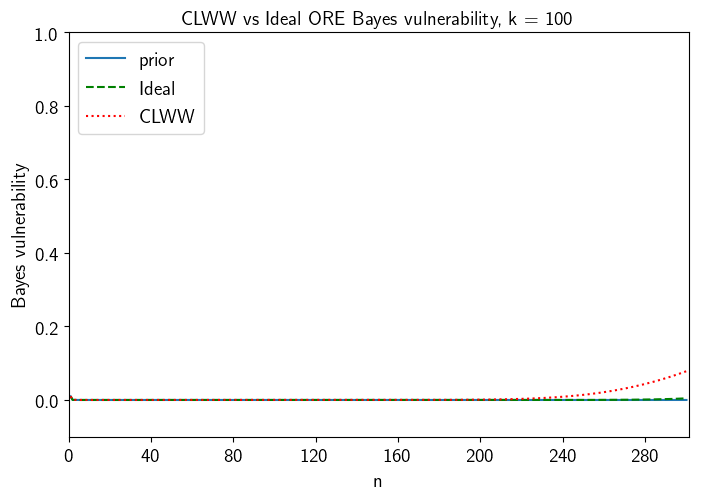

In [40]:
graph_it_nfunct(n_range, k, df_n)

### Function of k

#### Function of k, df

In [12]:
def df_kfunct(n, k_range, M): #M is df matrix
    k = 0
    k_list = []
    prior_list = []
    postIdeal_list = []
    postCLWW_list = []
    for x in range(k_range):
        k = k + 1
        k_list.append(k)
        prior = pow(1/k, n)
        prior_list.append(prior)
        clww = uni_ore_clww_bayes(n, k, M) #only dif
        postCLWW_list.append(clww)
        ideal = uni_ore_bayes(n, k)
        postIdeal_list.append(ideal)
    df = pd.DataFrame(
        {'k':k_list,
         'prior':prior_list,
         'postIdeal':postIdeal_list,
         'postCLWW': postCLWW_list
        }
    )
    return df

#### Function of k, graph code

In [13]:
def graph_it_kfunct(n, k_range, df):
    ax = plt.figure().gca()
    plt.plot('k', 'prior', 
             data=df,
             label='prior')
    plt.plot('k', 'postIdeal',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="Ideal")
    plt.plot('k', 'postCLWW',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="CLWW")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('k')
    plt.xlim(left = 0, right = k_range+1)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    plt.title('CLWW vs Ideal ORE Bayes vulnerability, n = {}'.format(n))
    plt.legend(loc='upper left') # legend adjusted so it doesn't run into annotations
    plt.show()
    plt.close()

#### Function of k, graphs

In [14]:
n = 100
k_range = 60
M = A
df_k = df_kfunct(n, k_range, M)

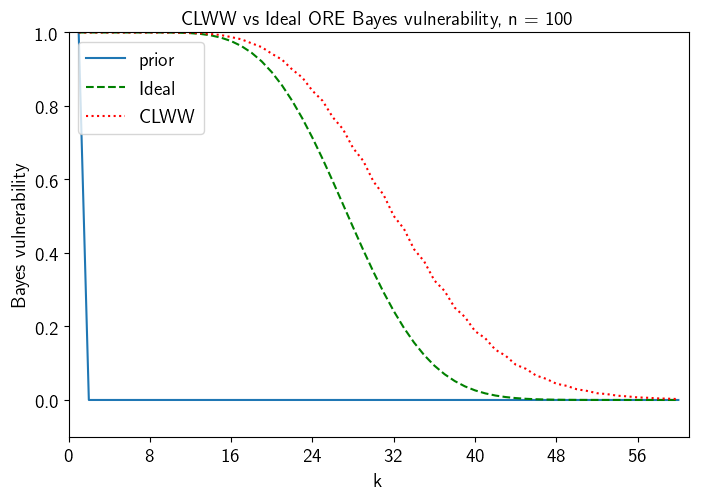

In [15]:
graph_it_kfunct(n, k_range, df_k)

### N and K together

#### N and K together, df

In [16]:
def df_nkfunc(nk_range, M): #M is df matrix
    nk = 0
    nk_list = []
    prior_list = []
    postIdeal_list = []
    postCLWW_list = []
    for x in range(nk_range):
        nk = nk + 1
        nk_list.append(nk)
        prior = pow(1/nk, nk)
        prior_list.append(prior)
        clww = uni_ore_clww_bayes(nk, nk, M)
        postCLWW_list.append(clww)
        ideal = uni_ore_bayes(nk, nk)
        postIdeal_list.append(ideal)
    df = pd.DataFrame(
        {'nk':nk_list,
         'prior':prior_list,
         'postIdeal':postIdeal_list,
         'postCLWW': postCLWW_list
        }
    )
    return df

#### N and K together, graph code

In [17]:
def graph_it_nk(nk_range, df):
    ax = plt.figure().gca()
    plt.plot('nk', 'prior', 
             data=df,
             label='prior')
    plt.plot('nk', 'postIdeal',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="Ideal")
    plt.plot('nk', 'postCLWW',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="CLWW")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n=k')
    plt.xlim(left = 0, right = nk_range+1)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    plt.title('CLWW vs Ideal ORE Bayes vulnerability, n and k together')
    plt.legend(loc='upper left') # legend adjusted so it doesn't run into annotations
    plt.show()
    plt.close()

#### N and K together, graphs

In [18]:
nk_range = 300
M = A
df_nk = df_nkfunc(nk_range, M)

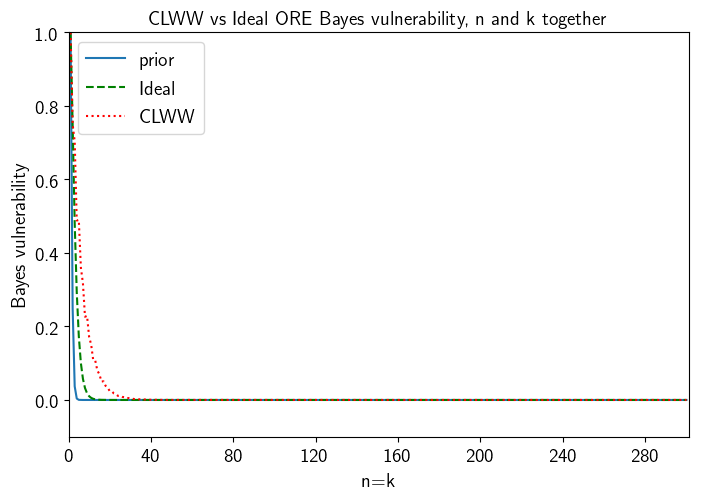

In [19]:
graph_it_nk(nk_range, df_nk)

### k = 2n

#### k = 2n, df

In [20]:
def df_2nkfunc(n_range, M): #M is df matrix
    n = 0
    n_list = []
    prior_list = []
    postIdeal_list = []
    postCLWW_list = []
    for x in range(n_range):
        n = n + 1
        k = 2*n
        n_list.append(n)
        prior = pow(1/k, n)
        prior_list.append(prior)
        clww = uni_ore_clww_bayes(n, k, M)
        postCLWW_list.append(clww)
        ideal = uni_ore_bayes(n, k)
        postIdeal_list.append(ideal)
    df = pd.DataFrame(
        {'n':n_list,
         'prior':prior_list,
         'postIdeal':postIdeal_list,
         'postCLWW': postCLWW_list
        }
    )
    return df

#### k = 2n, graph code

In [21]:
def graph_it_2nk(n_range, df):
    ax = plt.figure().gca()
    plt.plot('n', 'prior', 
             data=df,
             label='prior')
    plt.plot('n', 'postIdeal',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="Ideal")
    plt.plot('n', 'postCLWW',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="CLWW")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xlim(left = 0, right = n_range+1)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    plt.title('CLWW vs Ideal ORE Bayes vulnerability, k = 2n')
    plt.legend(loc='upper left') # legend adjusted so it doesn't run into annotations
    plt.show()
    plt.close()

#### k = 2n, graphs

In [22]:
n_range = 20
M = A
df_2nk = df_2nkfunc(n_range, M)

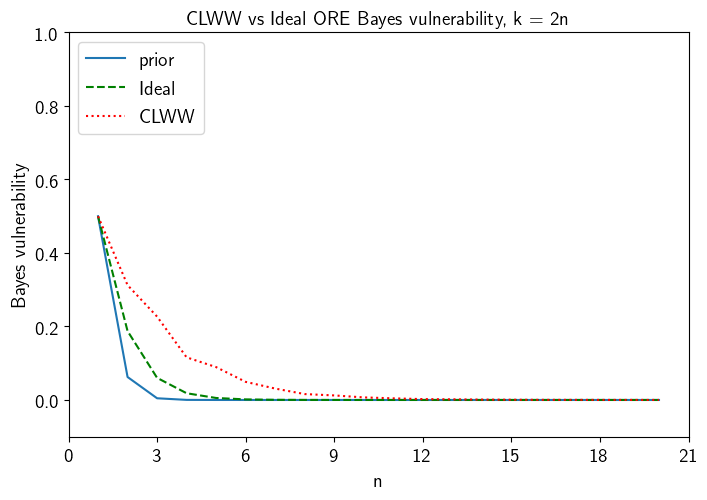

In [23]:
graph_it_2nk(n_range, df_2nk)